```c
    /\_/\           ___
   = o_o =_______    \ \  -my_3pt_king.ipynb-
    __^      __(  \.__) )
(@)<_____>__(_____)____/
```

~ analysing stephen curry

### installation

In [14]:
pip install nba-api pandas numpy matplotlib seaborn scikit-learn xgboost streamlit

Defaulting to user installation because normal site-packages is not writeable
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached jsonschema-4.24.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.25.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 11.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 9.8 MB/s eta 0:00:00
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### fetching curry's data (nba_api)

In [ ]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
import pandas as pd, time

def fetch_curry_seasons(seasons, pause=1):
    """
    fetches Curry's shot chart data for specified seasons
    """
    curry = players.find_players_by_full_name("Stephen Curry")[0]
    all_df = []

    # Loop through each season and fetch data
    for season in seasons:
        print(f"Fetching {season}…")
        df = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=curry['id'],
            season_nullable=season,
            season_type_all_star='Regular Season',
            context_measure_simple='FGA'
        ).get_data_frames()[0]
        df['season'] = season
        all_df.append(df)
        time.sleep(pause)

    # Concatenate all DataFrames into one
    return pd.concat(all_df, ignore_index=True)

# Fetch last 5 seasons
seasons = ['2018-19','2019-20','2020-21','2021-22','2022-23', '2023-24', '2024-25']
df_raw = fetch_curry_seasons(seasons)

# Save
df_raw.to_csv('../data/raw/curry_2018to25.csv', index=False)

Fetching 2018-19…
Fetching 2019-20…
Fetching 2020-21…
Fetching 2021-22…
Fetching 2022-23…
Fetching 2023-24…
Fetching 2024-25…


### cleaning + feature engineering

In [19]:
import pandas as pd, numpy as np

# Load raw multi‑season
df = pd.read_csv('../data/raw/curry_2018to25.csv')

# Standardize colnames
df.columns = df.columns.str.lower()

# Select relevant cols
keep = [
    'game_id','game_date','season','period','minutes_remaining','seconds_remaining',
    'shot_distance','loc_x','loc_y','shot_type','shot_zone_basic',
    'shot_zone_area','shot_zone_range','shot_made_flag'
]
df = df[keep]

# Time remaining (s)
df['time_remaining'] = df.minutes_remaining*60 + df.seconds_remaining

# Shot angle (deg)
df['shot_angle'] = np.degrees(np.arctan2(df.loc_x, df.loc_y))

# Flag 3PT
df['is_3pt'] = df.shot_distance >= 23

# Early vs Late game
df['game_segment'] = np.where(df.period<=2, 'early', 'late')

# Clutch (<10s)
df['is_clutch'] = df.time_remaining < 10

# Save processed
df.to_csv('../data/processed/cleaned_curry_2018to25.csv', index=False)

### shot chart

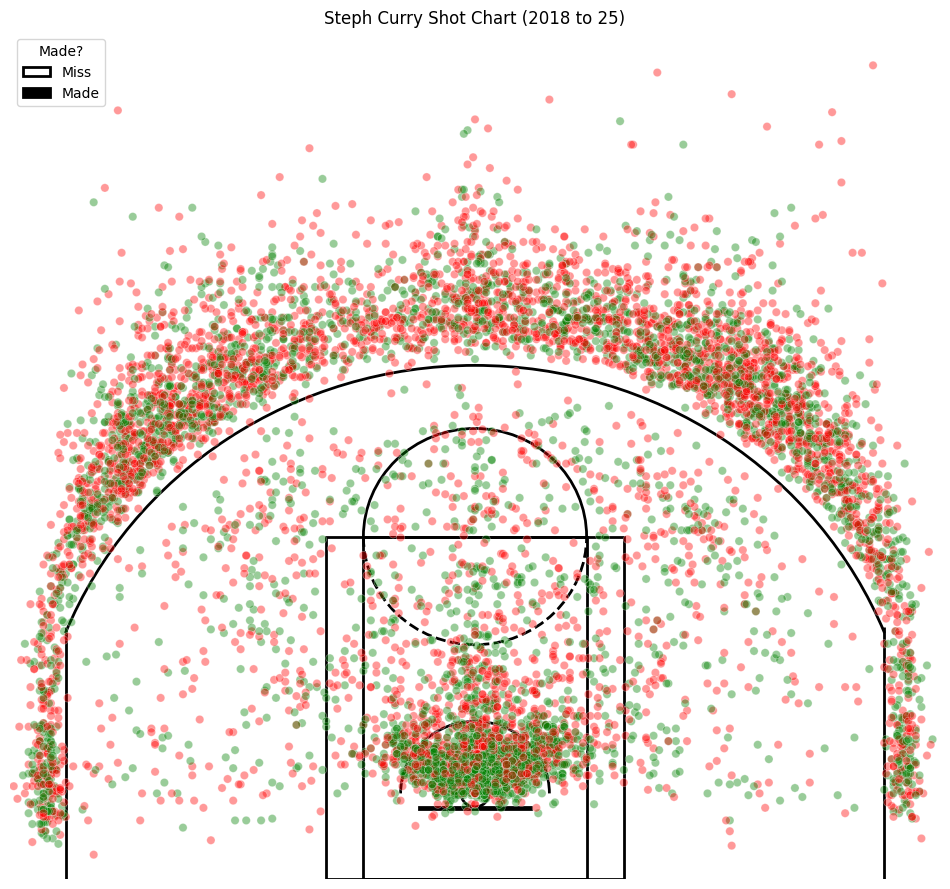

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns
from court import draw_half_court

df = pd.read_csv('../data/processed/cleaned_curry_2018to25.csv')

plt.figure(figsize=(12,11))
ax = plt.gca()
draw_half_court(ax)

sns.scatterplot(
    data=df, x='loc_x', y='loc_y',
    hue='shot_made_flag',
    palette={1:'green', 0:'red'},
    alpha=0.4, ax=ax
)
plt.title("King Curry's Shot Chart (2018 to 25)")
plt.legend(title='Made?', labels=['Miss','Made'])
plt.show()
